In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

import re
import os
from glob import glob

In [2]:
data_dir = '../data/'
data_files = glob(os.path.join(data_dir, "iti-*_ntrials-*_noise-*_simulation.tsv"))
data_regex = re.compile(r".*?iti-(?P<iti>[0-9]+)_ntrials-(?P<ntrials>[0-9]+)_noise-(?P<noise>0.[0-9]+)_simulation.tsv")

df_collector = []
for dfile in data_files:
    mch = re.match(data_regex, dfile)
    attr_dict = mch.groupdict()
    
    df = pd.read_csv(dfile, sep='\t')
    nrows = len(df.index)
    
    df_dict = {k: [float(v)] * nrows for k,v in attr_dict.items()}
    
    df_add = pd.DataFrame.from_dict(df_dict)
    
    df_final = pd.concat([df, df_add], axis=1)
    
    df_collector.append(df_final)

    
    

In [3]:
df_wide = pd.concat(df_collector, axis=0, ignore_index=True)
df_wide["id"] = df_wide.index
col_names = {"corr_ew": "corr_obs-low",
             "corr_dr": "corr_obs-high",
             "true_corr_dr": "corr_truth-high",
             "true_corr_ew": "corr_truth-low"}
df_wide.rename(col_names, axis=1, inplace=True)

# effect size for observed 0.8 - 0.0
df_wide['corr_obs-delta'] = df_wide['corr_obs-high'] - df_wide['corr_obs-low']
# effect size for ground truth 0.8 - 0.0
df_wide['corr_truth-delta'] = df_wide['corr_truth-high'] - df_wide['corr_truth-low']

# discrepency between truth and observed for low
df_wide['corr_disc-low'] = df_wide['corr_truth-low'] - df_wide['corr_obs-low']

# discrepency between truth and observed for high
df_wide['corr_disc-high'] = df_wide['corr_truth-high'] - df_wide['corr_obs-high']
df_wide.head()

,num,corr_obs-low,corr_truth-low,corr_obs-high,corr_truth-high,snr,iti,ntrials,noise,id,corr_obs-delta,corr_truth-delta,corr_disc-low,corr_disc-high
0,0,-0.031667,-0.044370,0.061628,0.735546,1.428565,10.0,90.0,0.1,0,0.093295,0.779916,-0.012704,0.673918
1,1,0.167236,-0.382414,-0.059141,0.725196,1.369580,10.0,90.0,0.1,1,-0.226377,1.107610,-0.549650,0.784337
2,2,-0.021301,0.155121,0.111060,0.654097,1.441149,10.0,90.0,0.1,2,0.132360,0.498976,0.176421,0.543038
3,3,0.015464,0.212888,0.185867,0.596836,1.263267,10.0,90.0,0.1,3,0.170402,0.383948,0.197424,0.410969
4,4,-0.003093,0.097607,-0.019449,0.848929,1.498162,10.0,90.0,0.1,4,-0.016356,0.751322,0.100700,0.868378


In [4]:
# list the variables in order
itis = df_wide.iti.unique()
itis.sort()
ntrials = df_wide.ntrials.unique()
ntrials.sort()
noises = df_wide.noise.unique()
noises.sort()

In [5]:
# how well do the observed values correlate with the truth?
query = "noise == {noise} & iti == {iti} & ntrials == {ntrial}"
corr_dict = {'iti': [],
             'ntrials': [],
             'noise': [],
             'strgth': [],
             'corr': [],
             }
for iti in itis[1:]:
    for ntrial in ntrials:
        for noise in noises:
            for strgth in ["high", "low"]:
                rquery = query.format(iti=str(iti),
                                      ntrial=str(ntrial),
                                      noise=str(noise))
                tmp_df = df_wide.query(rquery)
                corr = np.corrcoef(tmp_df[['corr_truth-' + strgth, 'corr_obs-' + strgth]], rowvar=False)[0,1]
                tmp_df[['corr_truth-' + strgth, 'corr_obs-' + strgth]]
                print("iti: {iti}, ntrial: {ntrial}, noise: {noise}, str: {strgth} corr: {corr}".format(iti=str(iti), 
                                                                                                        ntrial=str(ntrial),
                                                                                                        noise=str(noise),
                                                                                                        corr=str(corr),
                                                                                                        strgth=strgth))
                corr_dict['iti'].append(iti)
                corr_dict['ntrials'].append(ntrial)
                corr_dict['noise'].append(noise)
                corr_dict['strgth'].append(strgth)
                corr_dict['corr'].append(corr)

df_corr = pd.DataFrame.from_dict(corr_dict)
df_corr.head()

iti: 4.0, ntrial: 30.0, noise: 0.001, str: high corr: 0.27062975422262064
iti: 4.0, ntrial: 30.0, noise: 0.001, str: low corr: 0.4221996706964973
iti: 4.0, ntrial: 30.0, noise: 0.01, str: high corr: 0.2668318940522804
iti: 4.0, ntrial: 30.0, noise: 0.01, str: low corr: 0.3760955251414892
iti: 4.0, ntrial: 30.0, noise: 0.1, str: high corr: 0.03317385011057736
iti: 4.0, ntrial: 30.0, noise: 0.1, str: low corr: 0.03909664693363392
iti: 4.0, ntrial: 60.0, noise: 0.001, str: high corr: 0.3781751552018449
iti: 4.0, ntrial: 60.0, noise: 0.001, str: low corr: 0.43645126478676394
iti: 4.0, ntrial: 60.0, noise: 0.01, str: high corr: 0.3484420804994983
iti: 4.0, ntrial: 60.0, noise: 0.01, str: low corr: 0.3597386624479271
iti: 4.0, ntrial: 60.0, noise: 0.1, str: high corr: 0.11275267086003027
iti: 4.0, ntrial: 60.0, noise: 0.1, str: low corr: 0.07252323705052183
iti: 4.0, ntrial: 90.0, noise: 0.001, str: high corr: 0.3807362655103749
iti: 4.0, ntrial: 90.0, noise: 0.001, str: low corr: 0.54082491

,iti,ntrials,noise,strgth,corr
0,4.0,30.0,0.001,high,0.270630
1,4.0,30.0,0.001,low,0.422200
2,4.0,30.0,0.010,high,0.266832
3,4.0,30.0,0.010,low,0.376096
4,4.0,30.0,0.100,high,0.033174


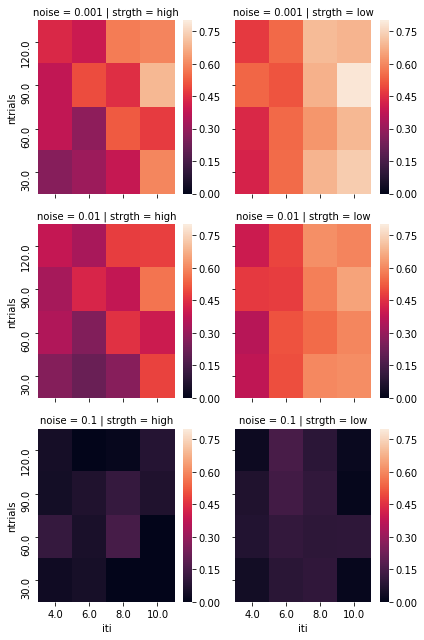

In [7]:
# show how well the observed correlations "correlate" with the ground truth correlations
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d = d[::-1]
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(df_corr, col='strgth', row='noise')
fg.map_dataframe(draw_heatmap, 'iti', 'ntrials', 'corr', vmin=0, vmax=0.8)

In [25]:
ttest_dict = {
    'p_value': [],
    't_value': [],
    'source': [],
    'iti': [],
    'ntrials': [],
    'noise': [],
    'df': [],
}

for iti in itis[1:]:
    for ntrial in ntrials:
        for noise in noises:
            rquery = query.format(iti=str(iti),
                                      ntrial=str(ntrial),
                                      noise=str(noise))
            tmp_df = df_wide.query(rquery)
            for source in ["truth", "obs"]:
                t_val, p_val, deg_f = ttest_ind(tmp_df["corr_{src}-high".format(src=source)],
                                            tmp_df["corr_{src}-low".format(src=source)])
                
                ttest_dict['iti'].append(iti)
                ttest_dict['ntrials'].append(ntrial)
                ttest_dict['noise'].append(noise)
                ttest_dict['p_value'].append(p_val)
                ttest_dict['t_value'].append(t_val)
                ttest_dict['df'].append(deg_f)
                ttest_dict['source'].append(source)

ttest_df = pd.DataFrame.from_dict(ttest_dict)
ttest_df.head()
                

,p_value,t_value,source,iti,ntrials,noise,df
0,0.000000e+00,61.802717,truth,4.0,30.0,0.001,998.0
1,1.779914e-56,16.888598,obs,4.0,30.0,0.001,998.0
2,0.000000e+00,61.802717,truth,4.0,30.0,0.010,998.0
3,1.767587e-39,13.741156,obs,4.0,30.0,0.010,998.0
4,0.000000e+00,61.802717,truth,4.0,30.0,0.100,998.0


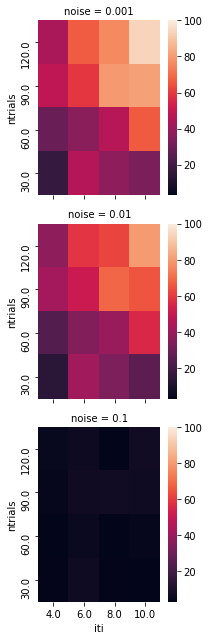

In [29]:
# show how t-values are modulated by trial number and iti
ttest_filt_df = ttest_df.query("source == 'obs'")

fg = sns.FacetGrid(ttest_filt_df, row='noise')
fg.map_dataframe(draw_heatmap, 'iti', 'ntrials', 't_value', vmin=3, vmax=100)

In [13]:
# make the correlations in one column
# ew = 0.0, dr = 0.8 (corr_str)
# (corr_ew, corr_dr) = observed, (true_corr_ew, true_corr_dr) = truth

df_long = pd.wide_to_long(df_wide, stubnames='corr', i='id', j="source-corr_str", sep="_", suffix="\\D+")
# id and source-corr_str became a part of the index
df_long.reset_index(inplace=True)
# split the source-corr_str columns
df_long[['source','corr_str']] = df_long['source-corr_str'].str.split("-",expand=True,)
# drop the no longer necessary columns
df_long.drop(labels=["id", "source-corr_str"], axis=1, inplace=True)
df_long.head()

,iti,num,ntrials,noise,snr,corr,source,corr_str
0,10.0,0,90.0,0.1,1.428565,-0.031667,obs,low
1,10.0,1,90.0,0.1,1.369580,0.167236,obs,low
2,10.0,2,90.0,0.1,1.441149,-0.021301,obs,low
3,10.0,3,90.0,0.1,1.263267,0.015464,obs,low
4,10.0,4,90.0,0.1,1.498162,-0.003093,obs,low


In [17]:
df_long_raw = df_long.query("corr_str != 'delta' & source != 'disc'")
df_long_deriv = df_long.query("corr_str == 'delta' & source == 'disc'")

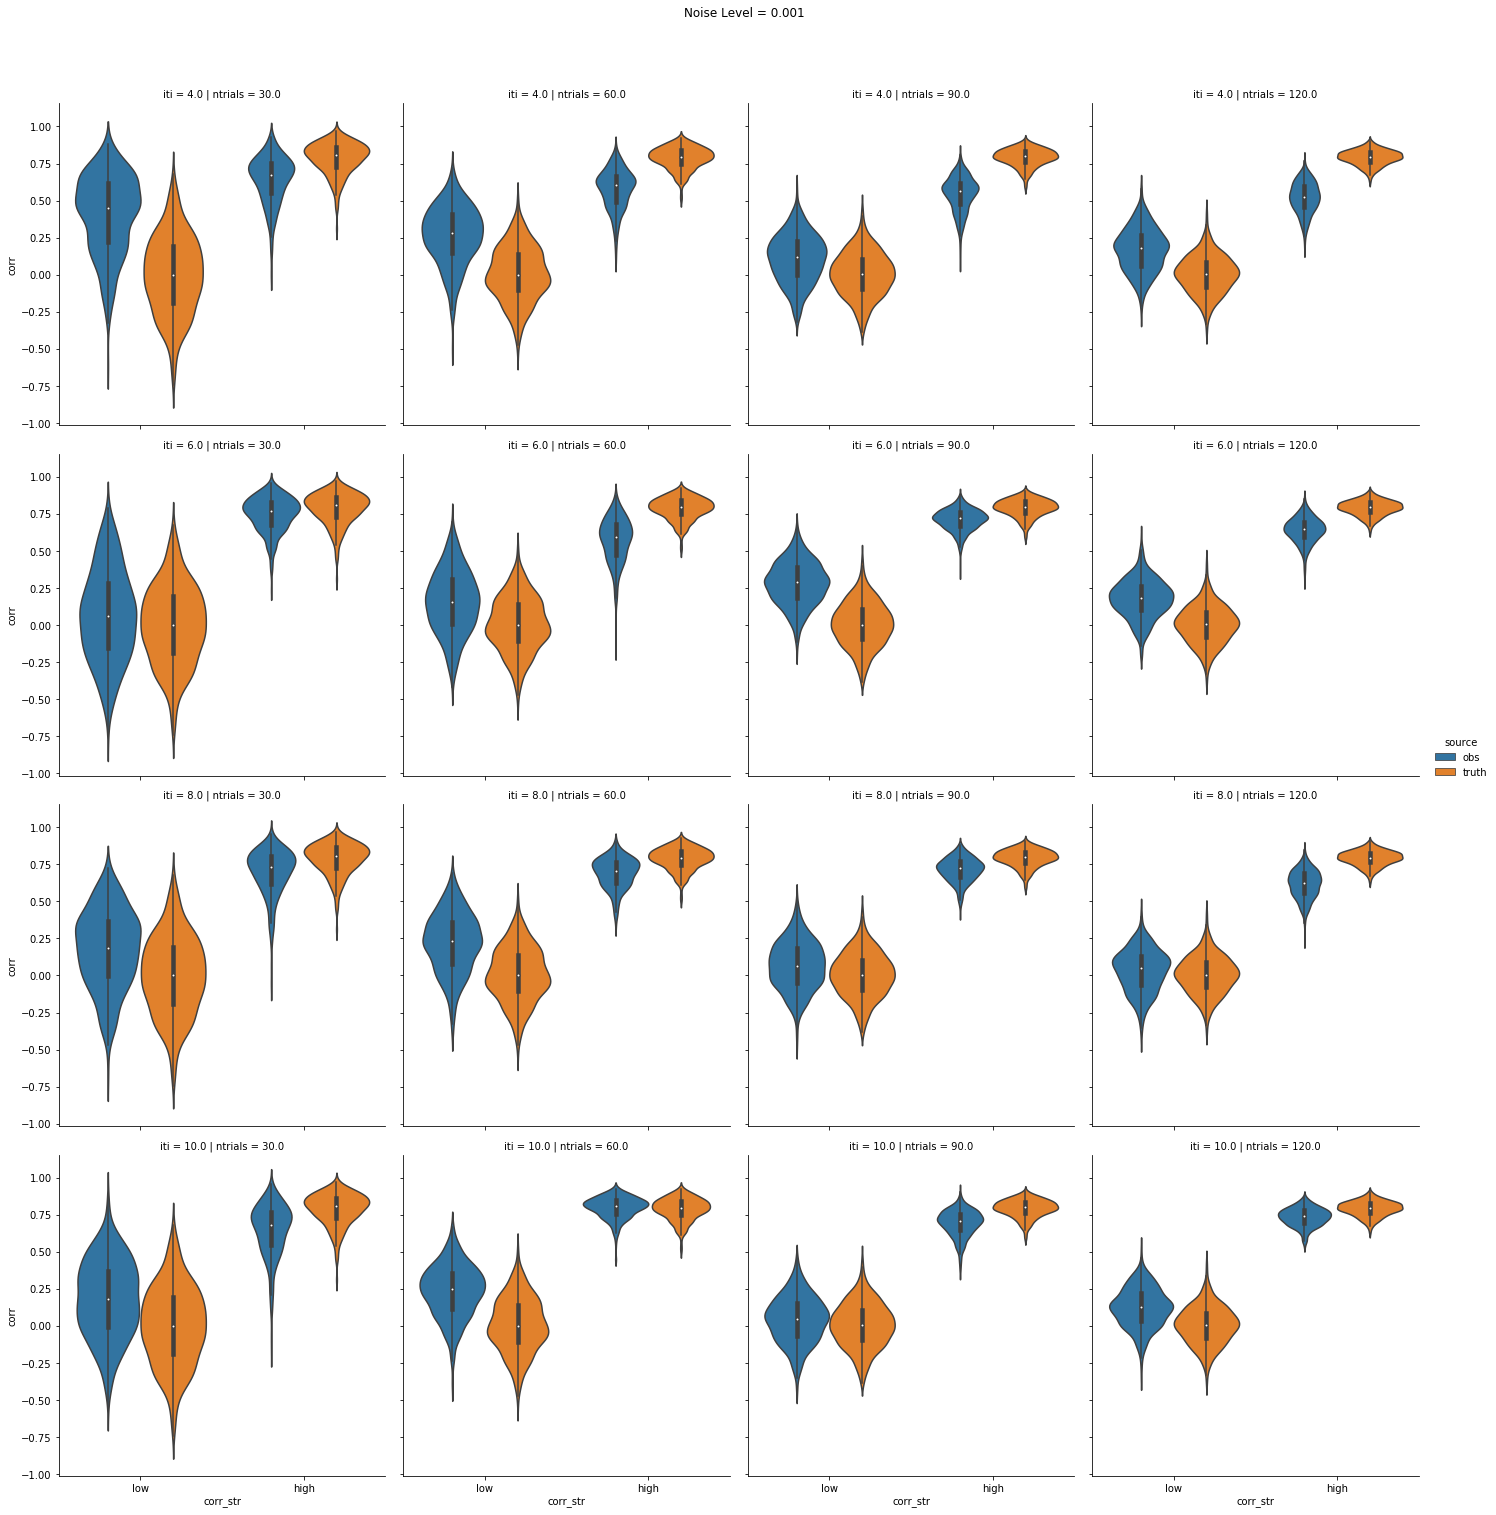

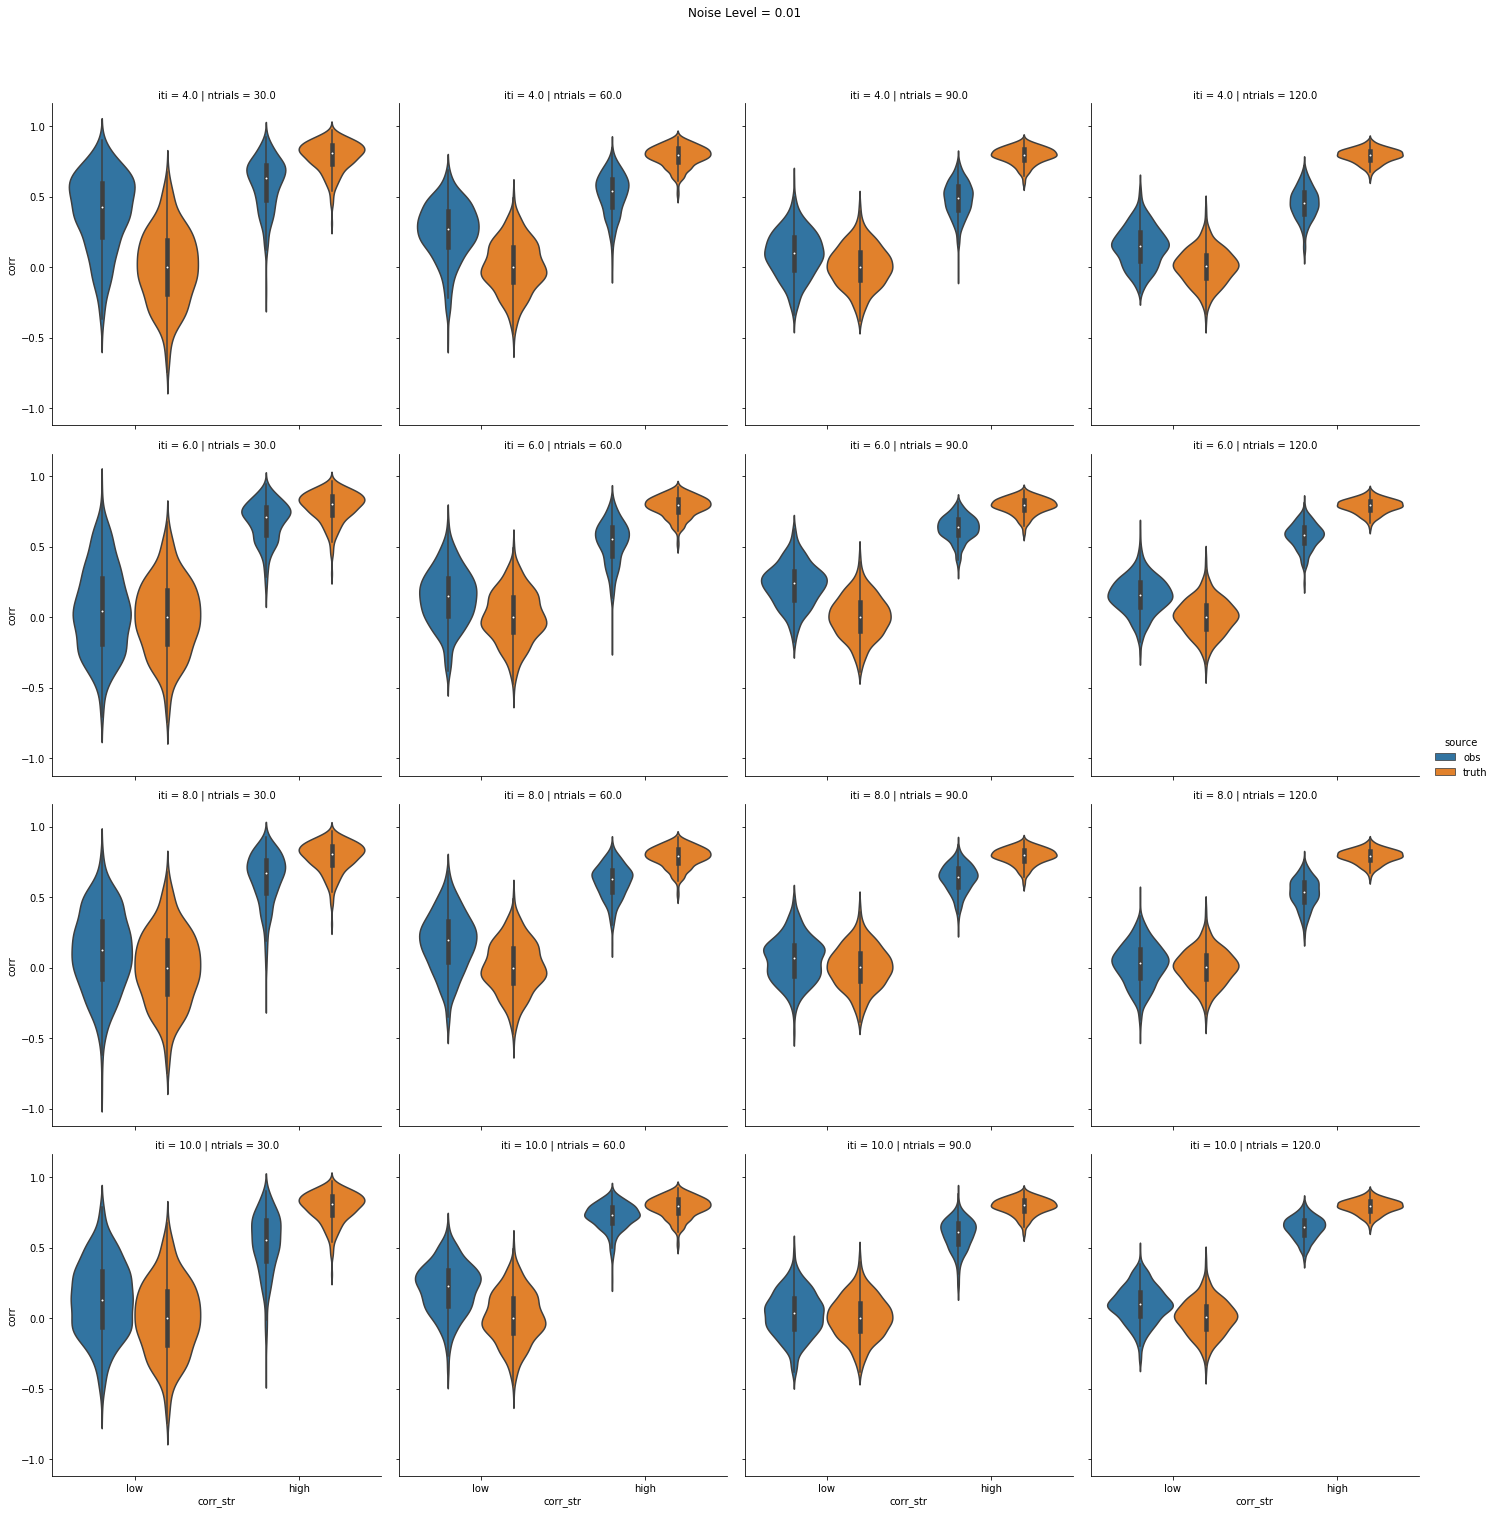

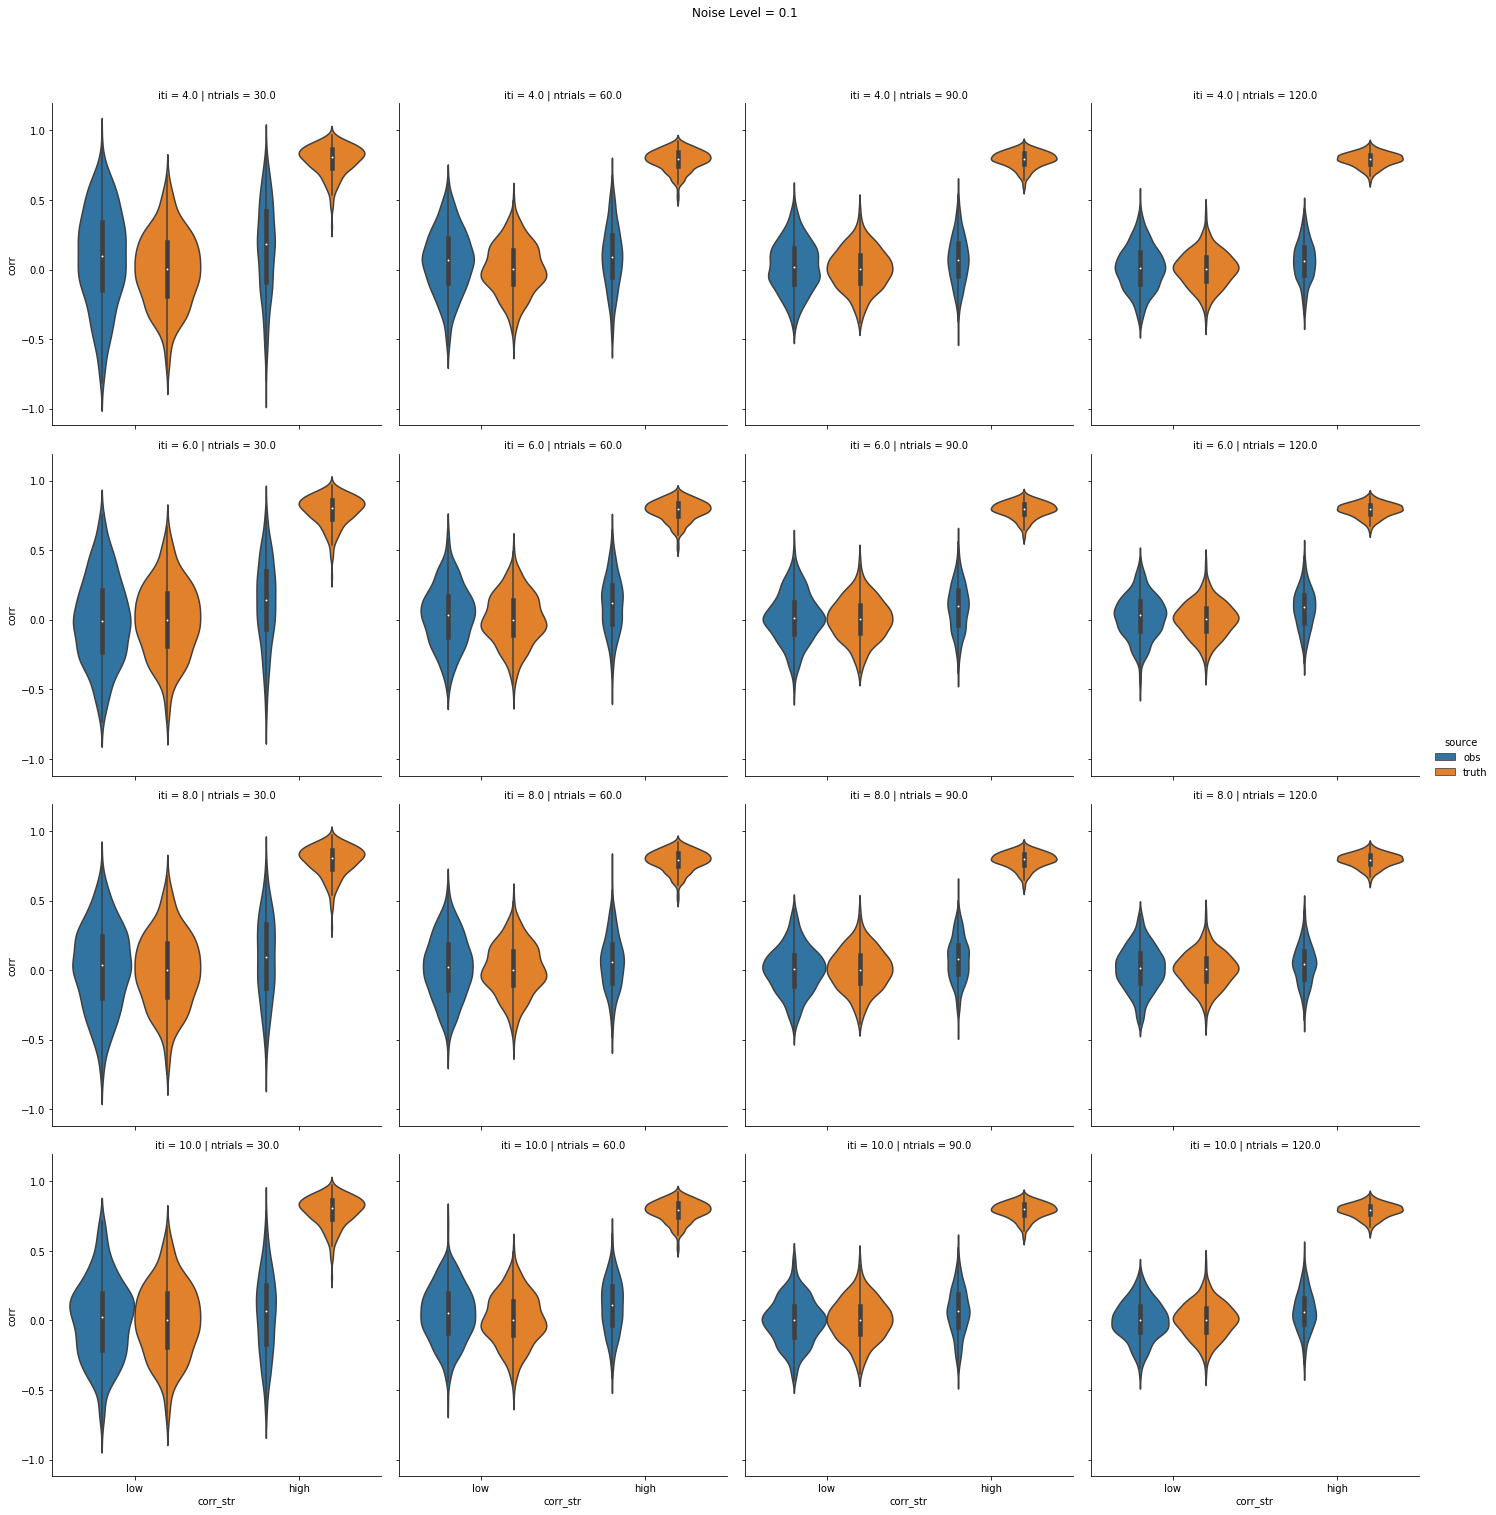

In [30]:
# show the average correlations across different conditions
for noise in noises:
    g = sns.catplot(x="corr_str", y="corr", hue="source",
                    row="iti", row_order=itis[1:],
                    col="ntrials", col_order=ntrials,
                    kind="violin", data=df_long_raw.query('noise == {noise} & iti != 2.'.format(noise=noise)))
    g.fig.suptitle('Noise Level = {noise}'.format(noise=noise), y=1.05)
    plt.show()